# 6 datasets tested. Train datasets contain all users except 1, Test datasets contain the missed out user. 

*   1, 1.5, 2 and 3 second windows tested
*   0 degree aspect angle
*   All movements
*   Cnn 64_128 model
*   Datsets:
    * 1: Miss out A
    * 2: Miss out B
    * 3: Miss out C
    * 4: Miss out D
    * 5: Miss out E
    * 6: Miss out F

## Train or Load Toggle
This variable sets whether to load results or train the model.
* If set to True then the model will be trained, history saved, new graphs generated and saved and new analysis produced.
* If set to False then a pre-trained version of the model will be loaded along with a history object.

In [1]:
TRAIN_MODEL_3s = False
TRAIN_MODEL_2s = True
TRAIN_MODEL_1_5_s = False
TRAIN_MODEL_1s = False

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [2]:
# Needed to allow editing using PyCharm
%load_ext autoreload
%autoreload 2

Needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [3]:
import os
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif os.getcwd() == 'D:\\Google Drive\\Level-4-Project\\notebooks\\baseline_models':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
else:
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/'
DATA_SETS = ["dataset_1/", "dataset_2/", "dataset_3/", "dataset_4/", "dataset_5/", "dataset_6/"]

MODELS_PATH = BASE_PATH + 'models/baseline_model/leave_one_user_out_cnn_64_128/'
RESULTS_PATH = BASE_PATH + 'results/baseline_model/leave_one_user_out_cnn_64_128/'
REPORT_PATH = BASE_PATH + 'reports/baseline_model/leave_one_user_out_cnn_64_128/'
    
from src.models.original_models import cnn_64_128
from src.data import load_data
from src.visualization import multiple_plots, visualize

Using TensorFlow backend.


Import remaining packages

In [4]:
import numpy as np
import sys
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model
import pickle

In [5]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup and Parameter Definition

In [6]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)
batch_size = 100
nb_epoch = 20
nb_epoch = 1

# input image dimensions
img_rows, img_cols = 75, 75

load_datasets takes in the window size (1, 1.5, 2 or 3) as a string combines with an array datasets of the form ["dataset_1/", "dataset_2/",...].

Returned is a dictionary indexed by dataset name which contains the training and testing sets.

In [7]:
def load_datasets(window_size, datasets):
    datasets = {}
    # Loop through each dataset 1,2,3,4,5,6
    for dataset in DATA_SETS:
        # load the training and testing sets
        loaded_data = load_data.load_dataset(DATA_PATH + window_size + "/" + dataset)
        # convert class vectors to binary class matrices
        y_train = np_utils.to_categorical(loaded_data["train_labels"], nb_classes)
        y_test = np_utils.to_categorical(loaded_data["test_labels"], nb_classes)
        x_train = loaded_data["train_data"].astype('float32')
        x_test = loaded_data["test_data"].astype('float32')
        x_train /= 255
        x_test /= 255 
        # [:-1] removes backslash from string
        datasets[dataset[:-1]] = {
            "train_labels": y_train,
            "test_labels": y_test,
            "train_data": x_train,
            "test_data": x_test
        }
    return datasets

## Training and Evaluating Models

In [8]:
def train_model(train_data, train_labels, test_data, test_labels):
    model = cnn_64_128.make_model(img_rows, img_cols, nb_classes)
    # train the model using SGD + momentum.
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    history = model.fit(
        train_data,
        train_labels,
        batch_size=batch_size,
        epochs=nb_epoch,
        validation_data=(test_data, test_labels),
        shuffle=True, 
        verbose=1)
    y_pred = model.predict_classes(test_data)
    report = classification_report(np.argmax(data["test_labels"],axis=1), y_pred,target_names=target_names)
    conf_matrix = confusion_matrix(np.argmax(data["test_labels"],axis=1), y_pred)
    return {"model": model, "history": history, "classification_report": report, "confusion_matrix": confusion_matrix}

In [10]:
def save_results(results, window_length):
    for dataset_name, result in results.items():
        model = result.pop["model"]
        model.save(MODELS_PATH + window_length + "/" + datset_name + '.h5')
    pickle.dump(results, open(RESULTS_PATH + window_length + "_results.pkl", "wb"))

In [12]:
def load_results(window_length):
    results = pickle.load(open(RESULTS_PATH + window_length + "_results.pkl", "rb"))
    for dataset_name, result in results.items():
        result["model"] = load_model(MODELS_PATH + window_length + "/" + datset_name + '.h5')

### 3 second window

In [13]:
results_3_seconds = {}
if TRAIN_MODEL_3s:
    datasets = load_datasets("3", DATA_SETS)
    results_3_seconds = {}
    for dataset_name, data in datasets.items():
        result = train_model(data["train_data"], data["train_labels"], data["test_data"], data["test_labels"])
        results_3_seconds[dataset_name] = result
    save_results(results_3_seconds, "3")
    
else:
    try:
        results_3_seconds = load_results("3")
    except:
        print("No saved file exists")

No saved file exists


### 2 second window

In [ ]:
results_2_seconds = {}
if TRAIN_MODEL_2s:
    datasets = load_datasets("2", DATA_SETS)
    results_2_seconds = {}
    for dataset_name, data in datasets.items():
        result = train_model(data["train_data"], data["train_labels"], data["test_data"], data["test_labels"])
        results_2_seconds[dataset_name] = result
    save_results(results_2_seconds, "2")

else:
    try:
        results_2_seconds = load_results("2")
    except:
        print("No saved file exists")

Train on 37635 samples, validate on 8106 samples
Epoch 1/1
37635/37635 [==============================] - 428s 11ms/step - loss: 0.6589 - acc: 0.7530 - val_loss: 0.1589 - val_acc: 0.9333
Train on 37635 samples, validate on 8106 samples
Epoch 1/1
27300/37635 [====================>.........] - ETA: 1:58 - loss: 0.7068 - acc: 0.7365

### 1.5 second window

In [ ]:
results_1_5_seconds = {}
if TRAIN_MODEL_1_5s:
    datasets = load_datasets("1_5", DATA_SETS)
    results_1_5_seconds = {}
    for dataset_name, data in datasets.items():
        result = train_model(data["train_data"], data["train_labels"], data["test_data"], data["test_labels"])
        results_1_5_seconds[dataset_name] = result
    save_results(results_1_5_seconds, "1_5")
else:
    try:
        results_1_5_seconds = load_results("1_5")
    except:
        print("No saved file exists")

### 1 second window

In [ ]:
results_1_seconds = {}
if TRAIN_MODEL_1s:
    datasets = load_datasets("1", DATA_SETS)
    results_1_seconds = {}
    for dataset_name, data in datasets.items():
        result = train_model(data["train_data"], data["train_labels"], data["test_data"], data["test_labels"])
        results_1_seconds[dataset_name] = result
    save_results(results_1_seconds, "1")
else:
    try:
        results_1_seconds = load_results("1")
    except:
        print("No saved file exists")

## Analysis and Saving of Results

In [17]:
save_graph = True
save_models = True
save_reports = True

In [14]:
# Renaming keys to make more meaninful (helps for reprots and graphing)
keys = list(datasets.keys())
for key in keys:
    print(key)
    if key == "dataset_1":
        datasets["Test on A"] = datasets.pop(key)
    elif key == "dataset_2":
        datasets["Test on B"] = datasets.pop(key)
    elif key == "dataset_3":
        datasets["Test on C"] = datasets.pop(key)
    elif key == "dataset_4":
        datasets["Test on D"] = datasets.pop(key)
    elif key == "dataset_5":
        datasets["Test on E"] = datasets.pop(key)
    elif key == "dataset_6":
        datasets["Test on F"] = datasets.pop(key)

Test on A


### Plot and Save graph

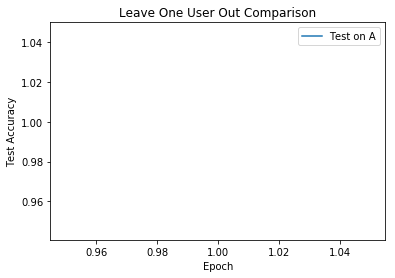

In [15]:
if not load_models:
    multiple_plots.plot_multiple_val_acc(
        datasets,
        "Leave One User Out Comparison",
        save=save_graph,
        path=REPORT_PATH + "leave_one_user_out_comparison.svg")

### Save Models

In [19]:
if not load_models and save_models:
    for name, model_data in datasets.items():
        model_data['model'].save(MODEL_PATH + name + '.h5')

### Save Classification Report and Confusion Matricies

In [20]:
if save_reports:
    file = open(REPORT_PATH + 'Classification_and_Confusion.txt', 'w') 

    for name, model_data in datasets.items():
        file.write("--------------------------------------------------\n") 
        file.write("Model Name: " + name + "\n") 
        file.write("Classification Report:\n") 
        file.write(model_data['classification_report'])
        file.write("Confusion Matrix:\n") 
        file.write(np.array2string(model_data['confusion_matrix']) + "\n")

    file.close() 